In [1]:
# Import statements and set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Swan Project, Analysis of Churners - Team 7
This notebook covers our exploration and prediction of the churning of customers within the Swan database provided.
## Exploratory Data Analysis
### Initial Checks
We first investigated the dataset to explore whether there was any anomalous data, as well as establishing basic insights into which types of customers are likely to churn and why they would do so.

In [2]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

Data Shape: (7043, 31)
Data Nulls:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64


We initially briefly investigate the nulls located within Churn Reason to establish the reason for this large number of nulls, finding that there are only nulls for 'Churn Reason' when the customer has not churned, which is wholly logical and thus means the data is consistent still with these nulls.

In [3]:
# this shows that the only null values are for reason when churn value is 0 which is wholly logical.
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

### Demographics of churners
We explore different visualisations of relationships between churners and different features within the dataset.
Prior to doing this we feature engineer our data so that it is in a format better oriented for our purposes.

In [6]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local


In [7]:
# Rename columns for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

# Convert total_charges to numeric
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges'] = df['total_charges'].fillna(df['total_charges'].median())

# Apply feature engineering
df = feature_engineering(df)

print("Feature engineering applied.")
display(df.head())

KeyError: "None of [Index(['Online Security', 'Online Backup', 'Device Protection', 'Tech Support',\n       'Streaming TV', 'Streaming Movies'],\n      dtype='object')] are in the [columns]"

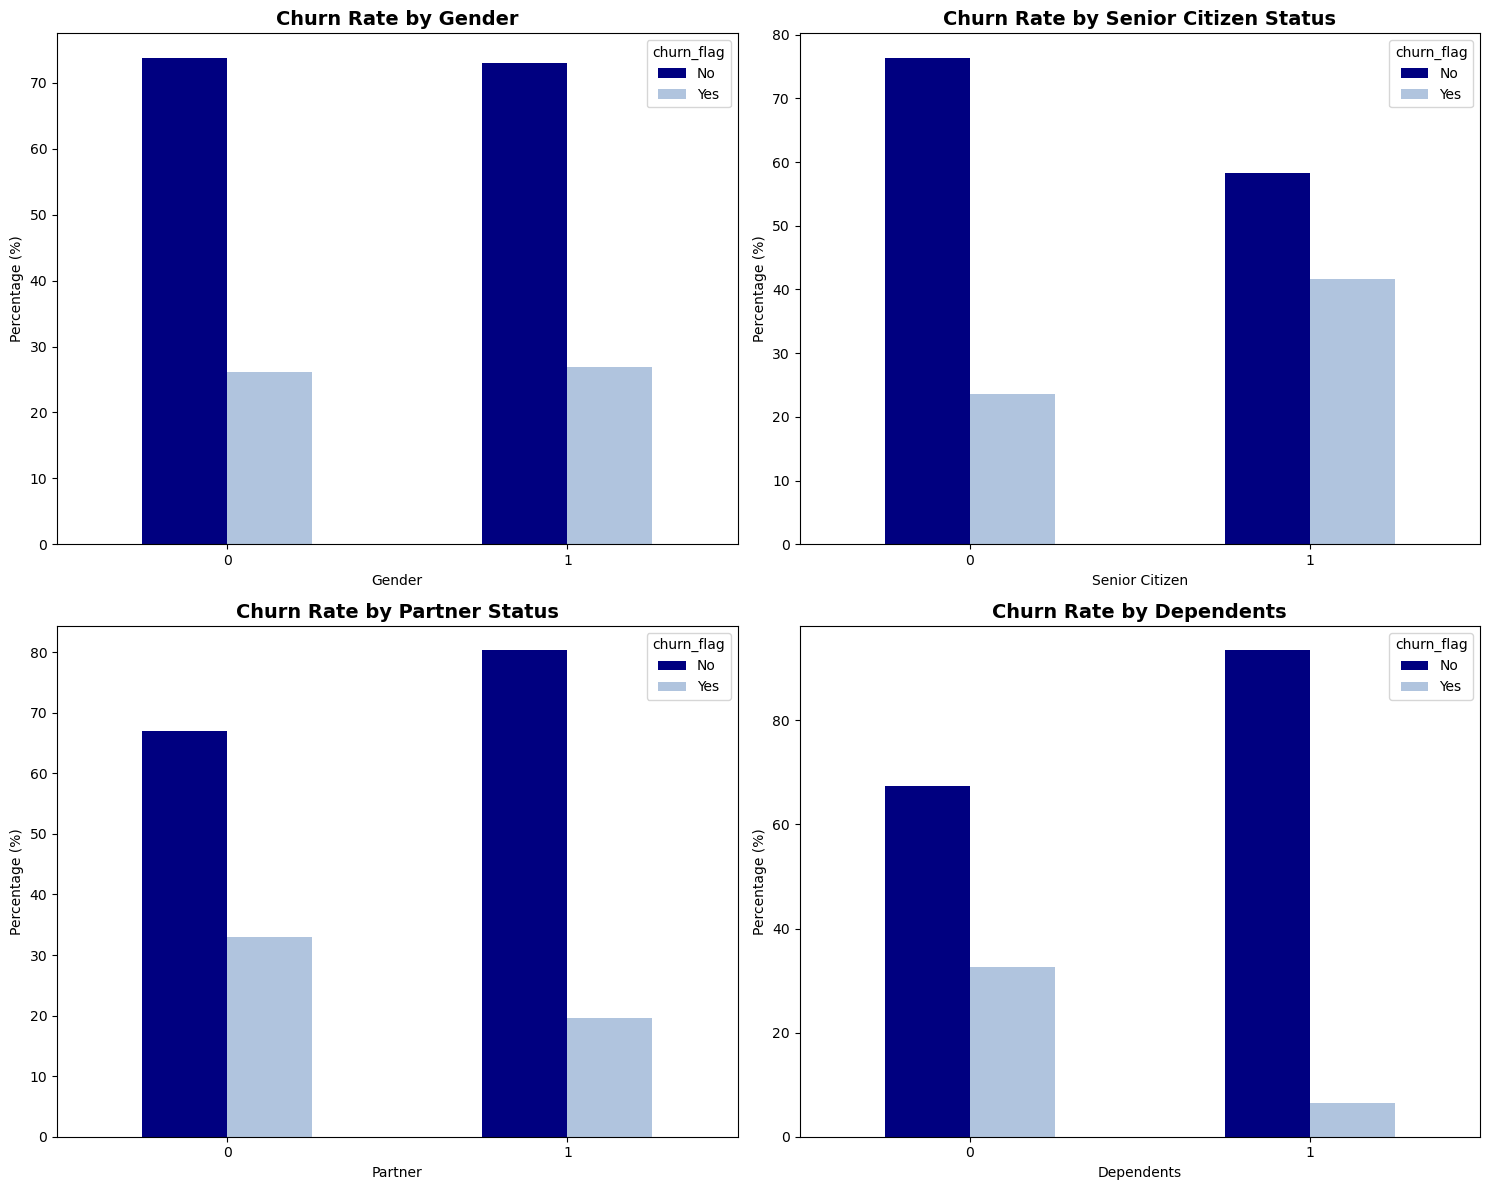

In [27]:
#Demographic Analysis - Cool Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Churn by Gender
gender_churn = pd.crosstab(df['Gender'], df['churn_flag'], normalize='index') * 100
gender_churn.plot(kind='bar', ax=axes[0,0], color=['navy', 'lightsteelblue'])
axes[0,0].set_title('Churn Rate by Gender', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Percentage (%)')
axes[0,0].tick_params(axis='x', rotation=0)

# Churn by Senior Citizen
senior_churn = pd.crosstab(df['Senior Citizen'], df['churn_flag'], normalize='index') * 100
senior_churn.plot(kind='bar', ax=axes[0,1], color=['navy', 'lightsteelblue'])
axes[0,1].set_title('Churn Rate by Senior Citizen Status', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Percentage (%)')
axes[0,1].tick_params(axis='x', rotation=0)

# Churn by Partner
partner_churn = pd.crosstab(df['Partner'], df['churn_flag'], normalize='index') * 100
partner_churn.plot(kind='bar', ax=axes[1,0], color=['navy', 'lightsteelblue'])
axes[1,0].set_title('Churn Rate by Partner Status', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Percentage (%)')
axes[1,0].tick_params(axis='x', rotation=0)

# Churn by Dependents
dependents_churn = pd.crosstab(df['Dependents'], df['churn_flag'], normalize='index') * 100
dependents_churn.plot(kind='bar', ax=axes[1,1], color=['navy', 'lightsteelblue'])
axes[1,1].set_title('Churn Rate by Dependents', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Percentage (%)')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

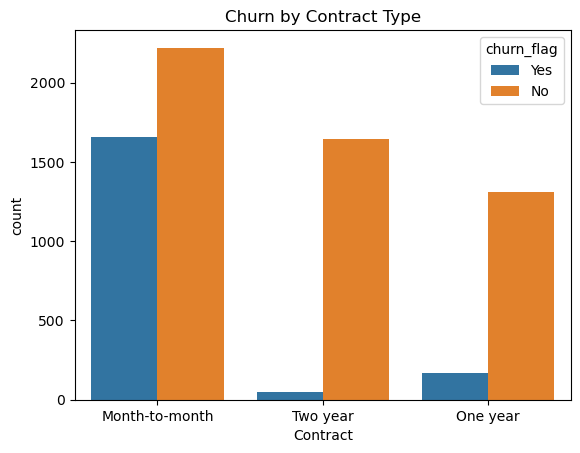

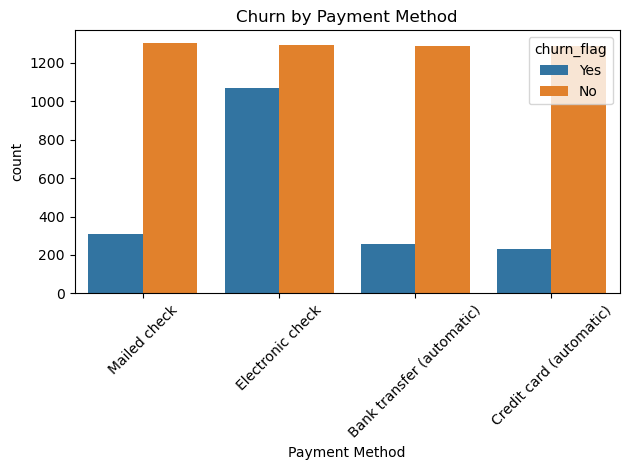

In [32]:
# Contract type & Payment method
sns.countplot(data=df, x='Contract', hue='churn_flag')
plt.title("Churn by Contract Type")
plt.show()

sns.countplot(data=df, x='Payment Method', hue='churn_flag')
plt.title("Churn by Payment Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

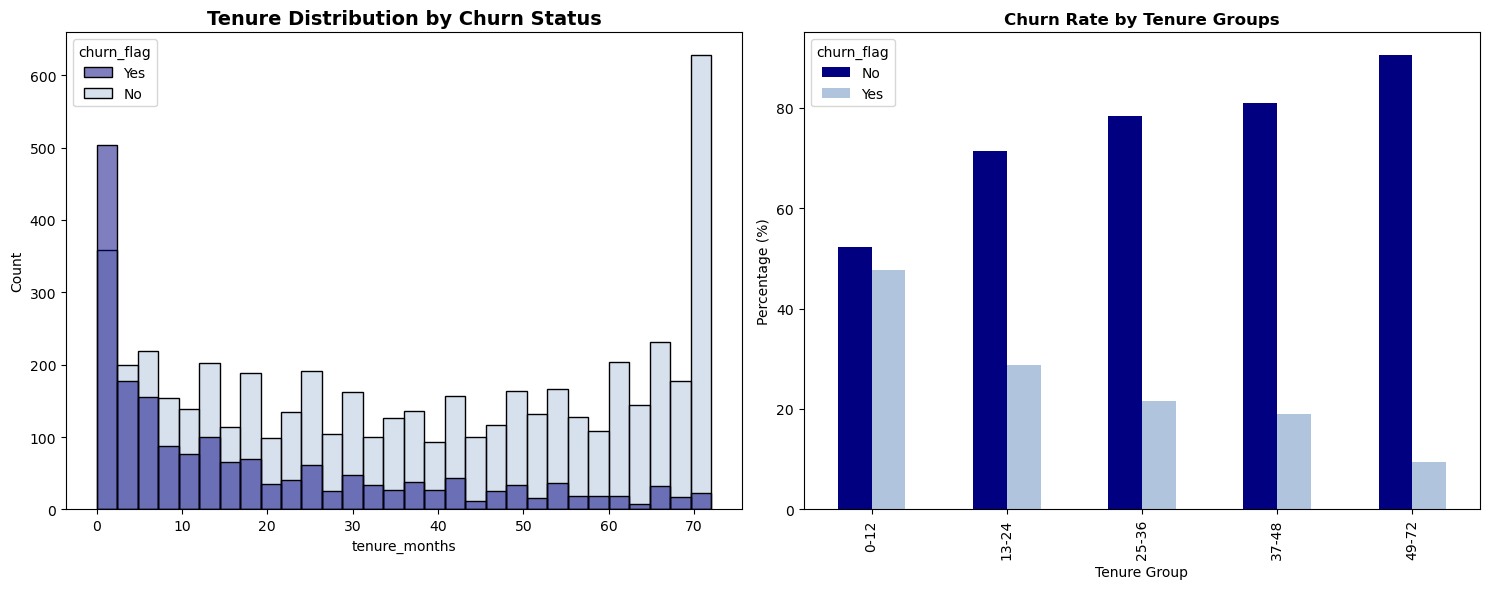

In [34]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tenure distribution by Churn
sns.histplot(data=df, x='tenure_months', hue='churn_flag', bins=30, ax=axes[0], palette=['navy', 'lightsteelblue'])
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')

# Churn rate by tenure groups
df['Tenure Group'] = pd.cut(df['tenure_months'], bins=[0, 12, 24, 36, 48, 72, 100], 
                           labels=['0-12', '13-24', '25-36', '37-48', '49-72', '73+'])
tenure_churn = pd.crosstab(df['Tenure Group'], df['churn_flag'], normalize='index') * 100
tenure_churn.plot(kind='bar', ax=axes[1], color=['navy', 'lightsteelblue'])
axes[1].set_title('Churn Rate by Tenure Groups', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

### Churn Drivers
We investigated what led to customers churning.

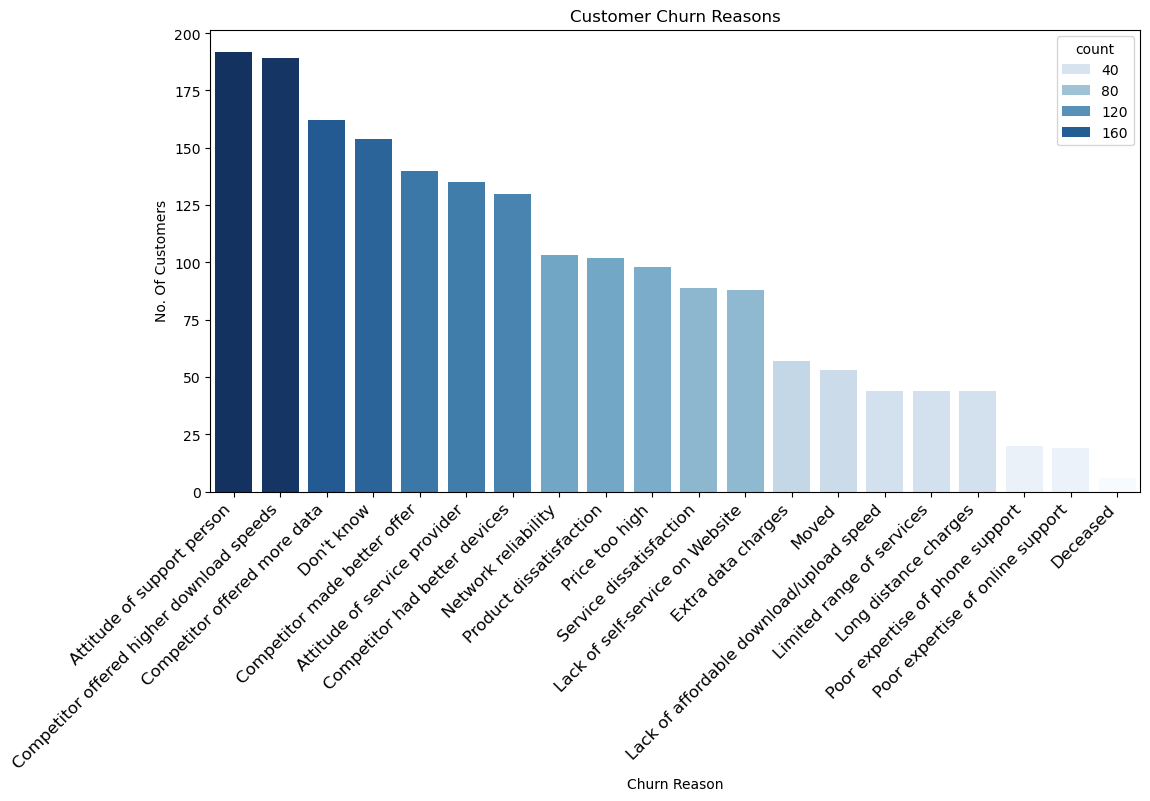

In [20]:
# Graphing the top reasons customers gave for churning
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette='Blues', hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons')
plt.show()

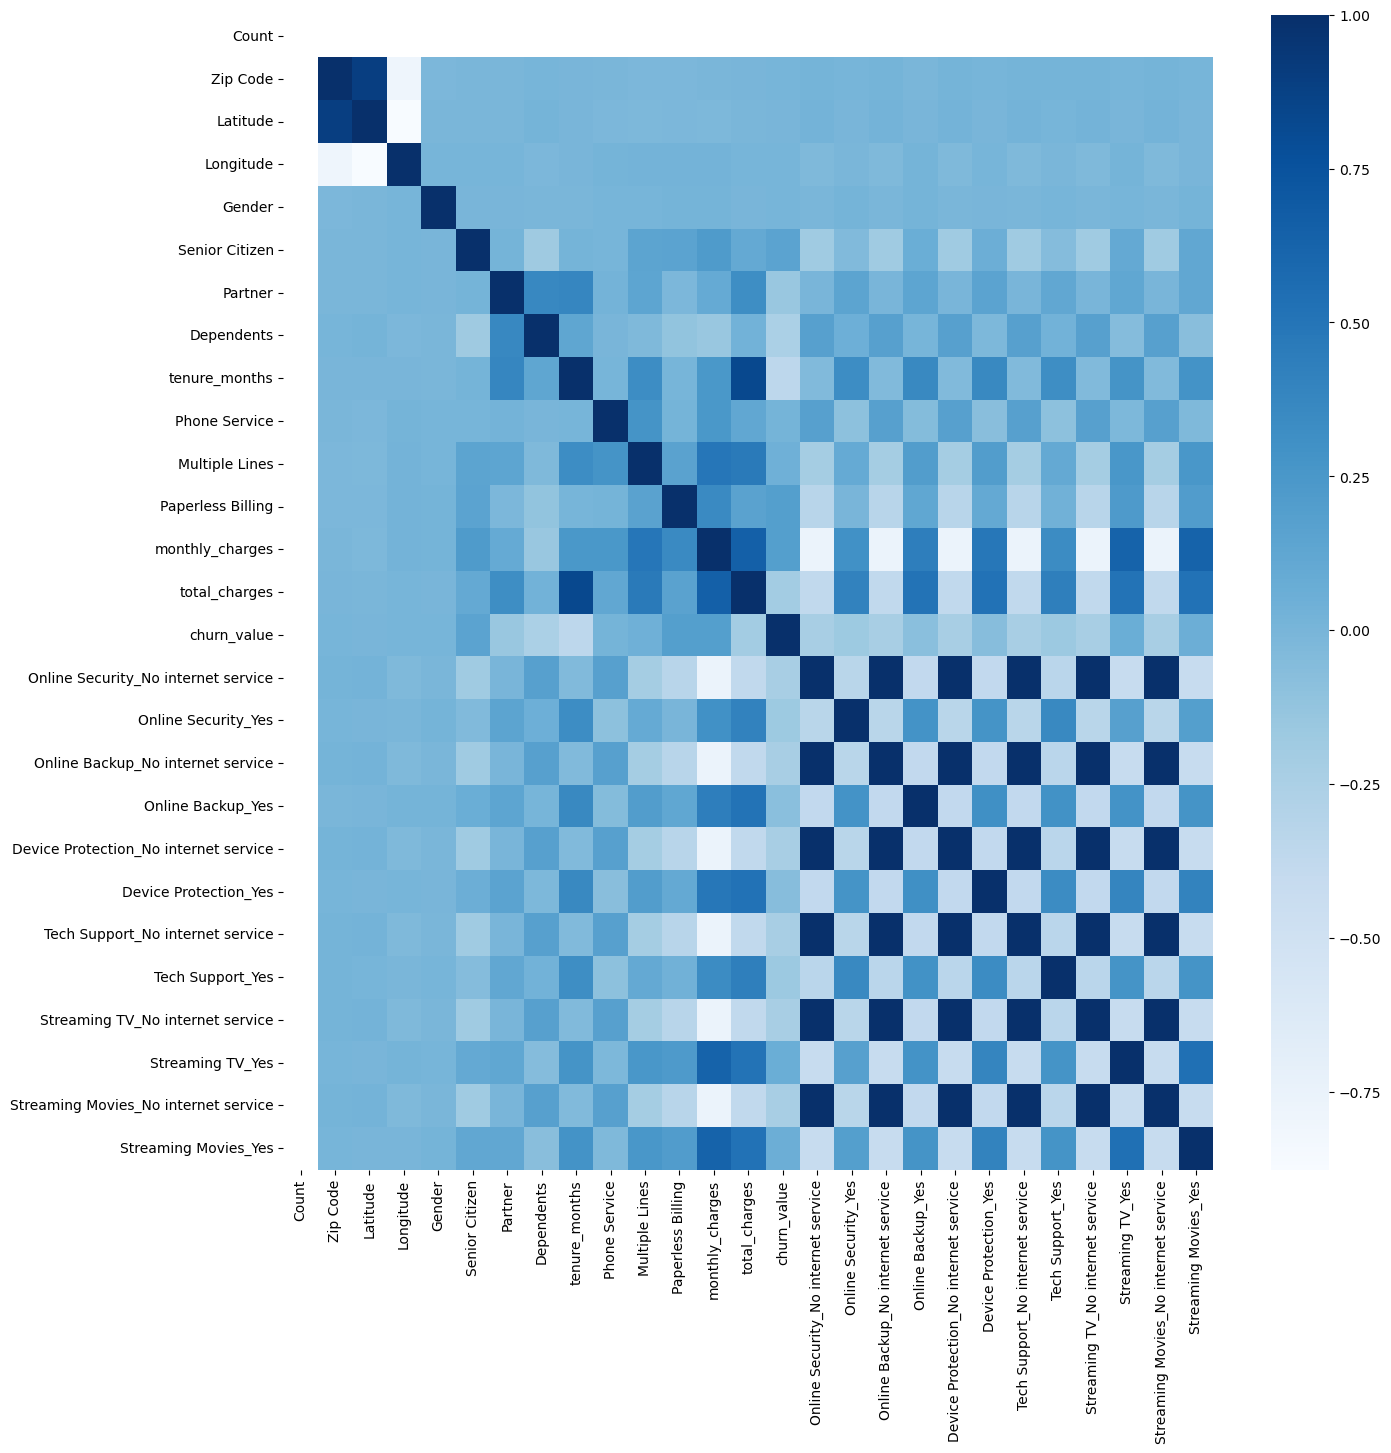

In [23]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (15,15))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = 'Blues')
plt.show()